# Construction and Test of DNN

In [123]:
import sys
sys.path.insert(0, '../')  # Notebook is in the 'notebooks' directory
from src.dbn import init_DBN, train_DBN
from src.rbm import entree_sortie_rbm
import numpy as np
from matplotlib import pyplot as plt
from src.data_utils import lire_alpha_digit
from src.dbn import DBN

In [83]:
def init_DNN(sizes, output_size=10):
    configuration = sizes + [output_size]
    return init_DBN(configuration)

In [92]:
# Load the data
data_path = '../data/binary_alpha_digits/binaryalphadigs.mat'
X = lire_alpha_digit(data_path, np.arange(5))
y_labels = []
for i in range(5):
    y_labels.extend([i] * (X.shape[0] // 5))
y = np.array(y_labels)
X.shape, y.shape

((195, 320), (195,))

In [117]:
dnn = init_DNN([320, 200, 200],5)
len(dnn['W']), dnn['W'][0].shape

(3, (320, 200))

In [102]:
def pretrain_DNN(X, dnn, epochs=100, learning_rate=0.1, batch_size=128):
    dbn= {'W': dnn['W'][:-1], 'a': dnn['a'][:-1], 'b': dnn['b'][:-1]}
    dbn = train_DBN(X, dbn, epochs=epochs, learning_rate=learning_rate, batch_size=batch_size)
    dnn['W'][:-1] = dbn['W']
    dnn['a'][:-1] = dbn['a']
    dnn['b'][:-1] = dbn['b']
    return dnn

In [118]:
dnn = pretrain_DNN(X, dnn, epochs=100, learning_rate=0.1, batch_size=32)

Training layer 1
Epoch 1/100, Mean Square Error : 0.543136935763889
Epoch 2/100, Mean Square Error : 0.5128526475694445
Epoch 3/100, Mean Square Error : 0.4776421440972222
Epoch 4/100, Mean Square Error : 0.4544813368055556
Epoch 5/100, Mean Square Error : 0.407004123263889
Epoch 6/100, Mean Square Error : 0.40619032118055554
Epoch 7/100, Mean Square Error : 0.3912868923611111
Epoch 8/100, Mean Square Error : 0.3748372395833333
Epoch 9/100, Mean Square Error : 0.3519042968750001
Epoch 10/100, Mean Square Error : 0.35126953125
Epoch 11/100, Mean Square Error : 0.33703342013888893
Epoch 12/100, Mean Square Error : 0.33238932291666673
Epoch 13/100, Mean Square Error : 0.317626953125
Epoch 14/100, Mean Square Error : 0.3201497395833333
Epoch 15/100, Mean Square Error : 0.29979383680555555
Epoch 16/100, Mean Square Error : 0.30111762152777777
Epoch 17/100, Mean Square Error : 0.29970703125000003
Epoch 18/100, Mean Square Error : 0.2919867621527778
Epoch 19/100, Mean Square Error : 0.2831271

In [96]:
def calcul_softmax(rbm, X):
    # Calculate the logits
    logits = np.dot(X, rbm['W']) + rbm['b']
    
    # Apply the softmax function
    exp_logits = np.exp(logits)
    softmax_probs = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
    
    return softmax_probs

In [97]:
def entree_sortie_reseau(DNN, X):
    sorties = [X]  # List to store the outputs of each layer
    proba_sortie = None  # Will store the output of the last layer
    
    for i in range(len(DNN['W'])-1):
        RBM = {'W': DNN['W'][i], 'a': DNN['a'][i], 'b': DNN['b'][i]}
        v = np.random.binomial(1, entree_sortie_rbm(RBM, sorties[-1]))
        sorties.append(v)
    RBM = {'W': DNN['W'][-1], 'a': DNN['a'][-1], 'b': DNN['b'][-1]}
    proba_sortie = calcul_softmax(RBM, sorties[-1])
    
    return sorties, proba_sortie

In [98]:
sorties, proba_sortie = entree_sortie_reseau(dnn, X)

In [99]:
sorties[0].shape, proba_sortie.shape

((195, 320), (195, 5))

In [114]:
def retropropagation(X, y, dnn, pretrained=True, epochs=100, learning_rate=0.1, batch_size=128, verbose=True, plot=True):
    min_loss = np.inf  # Initialize the minimum loss to infinity
    loss = []
    patience = 5
    wait = 0
    for epoch in range(epochs):
        # Shuffle the data
        indices = np.random.permutation(len(X))
        X_shuffled = X[indices]
        y_shuffled = y[indices]
        
        # Split the data into mini-batches
        num_batches = len(X) // batch_size
        X_batches = np.array_split(X_shuffled, num_batches)
        y_batches = np.array_split(y_shuffled, num_batches)
        
        loss_batches = []
        # Iterate over each mini-batch
        for X_batch, y_batch in zip(X_batches, y_batches):

            # Forward propagation
            sorties, proba_sortie = entree_sortie_reseau(dnn, X_batch)
            
            # Convert y_batch to one-hot encoded format
            num_classes = proba_sortie.shape[1]
            y_one_hot = np.eye(num_classes)[y_batch]

            # Loss calculation
            loss_batch = -np.mean(np.sum(y_one_hot * np.log(proba_sortie), axis=1))
            loss_batches.append(loss_batch)
            
            # Backward propagation
            # Last layer
            delta = proba_sortie - y_one_hot
            grad_W = np.dot(sorties[-1].T, delta) / batch_size
            grad_b = np.mean(delta, axis=0)
            dnn['W'][-1] -= learning_rate * grad_W
            dnn['b'][-1] -= learning_rate * grad_b

            # Hidden layers
            for i in range(2, len(dnn['W'])):
                if i == 2:  # Classification layer
                    RBM = {'W': dnn['W'][-1].T, 'a': dnn['a'][-1], 'b': dnn['b'][-1]}  # Transpose W
                    delta = np.dot(delta, RBM['W']) * sorties[-1] * (1 - sorties[-1])
                else:
                    RBM = {'W': dnn['W'][-i + 1].T, 'a': dnn['a'][-i + 1], 'b': dnn['b'][-i + 1]}
                    delta = np.dot(delta, RBM['W']) * sorties[-i] * (1 - sorties[-i])
                if i == len(dnn['W']) - 1:
                    grad_W = np.dot(X_batch.T, delta)
                else:
                    grad_W = np.dot(sorties[-i - 1].T, delta)
                
                grad_b = np.mean(delta, axis=0)
    
                # Update weights and biases
                dnn['W'][-i - 1] -= learning_rate * grad_W
                dnn['b'][-i - 1] -= learning_rate * grad_b


        # Calculate the cross entropy loss for the epoch
        train_loss = float(np.mean(loss_batches))
        loss.append(train_loss)
        if verbose:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss}")

        # Check for improvement
        if train_loss < min_loss:
            min_loss = train_loss  # Update minimum loss
            wait = 0  # Reset wait counter
        else:
            wait += 1  # Increment wait counter

        # Check for early stopping
        if wait >= patience:
            print("Early stopping due to no improvement in Loss.")
            break
        
          
    
    if plot:
        plt.plot(np.arange(len(loss)), loss)
        plt.xlabel("Epochs")
        plt.ylabel("CrossEntropy Loss")
        if pretrained:
            plt.title("Loss for pretrained DNN")
        else:
            plt.title("Loss for DNN (without pretraining)")
        plt.show()
    return dnn


Epoch 1/100, Loss: 1.2118640613289777
Epoch 2/100, Loss: 0.6786136252645529
Epoch 3/100, Loss: 0.4784296685489913
Epoch 4/100, Loss: 0.3577730749508557
Epoch 5/100, Loss: 0.2990486241984687
Epoch 6/100, Loss: 0.25727463685441787
Epoch 7/100, Loss: 0.2366465738095945
Epoch 8/100, Loss: 0.21008278990332616
Epoch 9/100, Loss: 0.20337947554817104
Epoch 10/100, Loss: 0.17846260098723185
Epoch 11/100, Loss: 0.17007213974016833
Epoch 12/100, Loss: 0.1562734437332253
Epoch 13/100, Loss: 0.14574018392848215
Epoch 14/100, Loss: 0.14002641076956673
Epoch 15/100, Loss: 0.12835743196482027
Epoch 16/100, Loss: 0.12327943368734369
Epoch 17/100, Loss: 0.12953121838721945
Epoch 18/100, Loss: 0.11439740918677921
Epoch 19/100, Loss: 0.12238572677262764
Epoch 20/100, Loss: 0.10887277911561559
Epoch 21/100, Loss: 0.10203068727936114
Epoch 22/100, Loss: 0.10700311242914701
Epoch 23/100, Loss: 0.09370057651852827
Epoch 24/100, Loss: 0.10048407590084081
Epoch 25/100, Loss: 0.0865902140169814
Epoch 26/100, Los

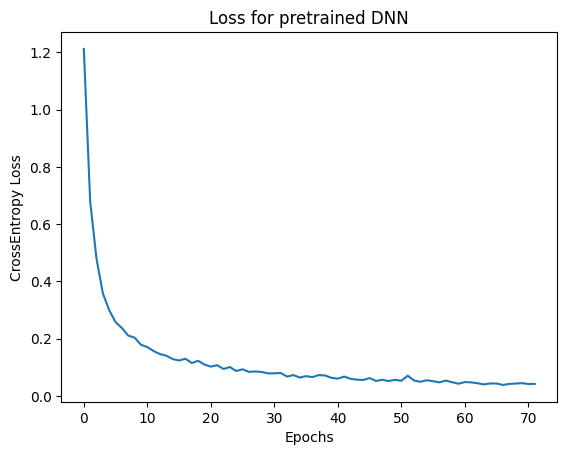

In [119]:
dnn = retropropagation(X, y, dnn, epochs=100, learning_rate=0.1, batch_size=32)

In [121]:
def test_dnn(X, y, dnn, verbose=True):
    _, proba_sortie = entree_sortie_reseau(dnn, X)
    predictions = np.argmax(proba_sortie, axis=1)
    accuracy = np.mean(predictions == y)
    if verbose :
        print(f"Accuracy: {accuracy}")
    return accuracy

In [122]:
def plot_proba(data, dnn, n =10):
    pred_labels = entree_sortie_reseau(dnn, data)[-1]
    plt.scatter(np.arange(0, n), pred_labels[0])
    plt.xlabel("Classes")
    plt.ylabel("Predicted probability for each class")
    plt.title("Probabilities by class")
    plt.show()